In [ ]:
from fastcore.transform import Pipeline

from fastai.data.block import CategoryBlock, DataBlock, RegressionBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import (Categorize, GrandparentSplitter, IntToFloatTensor, 
                                    Normalize, RandomSplitter, ToTensor, parent_label)

from fastai.torch_core import to_device
from fastai.vision.augment import aug_transforms, Resize, RandomResizedCrop, FlipItem
from fastai.vision.data import ImageBlock, PILImage, get_image_files, imagenet_stats
from fastcore.transform import Transform
import pandas as pd
from pathlib import Path
import torch
from fastai.vision.all import *


In [ ]:
item_tfms=Resize(128)
gen_url = Path("/Users/id/.fastai/data/chess_screenshots_tiny")

In [ ]:
class BoundingBoxTranform(Transform):
    def __init__(self, df):
        self.df = df
    def encodes(self, filename):
        idx = int(Path(filename).stem)
        _, _, x, y, dx, dy = tuple(df.iloc[idx].values.ravel())
        # todo: scale these per the image resize
        ratio = 224/500
        return torch.tensor((dx, dy, 400+dx, 400+dy))*ratio

In [ ]:
df = pd.read_csv('annotations.csv')

In [ ]:
batch_tfms = [Resize(224),
             Normalize.from_stats(*imagenet_stats)
             ]

In [ ]:
shots = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=4)),
        get_items=get_image_files,
         splitter=RandomSplitter(seed=42),
         get_y = Pipeline(BoundingBoxTranform(df)),
          item_tfms=item_tfms,
          batch_tfms=batch_tfms,
)

In [ ]:
dls = shots.dataloaders(gen_url)

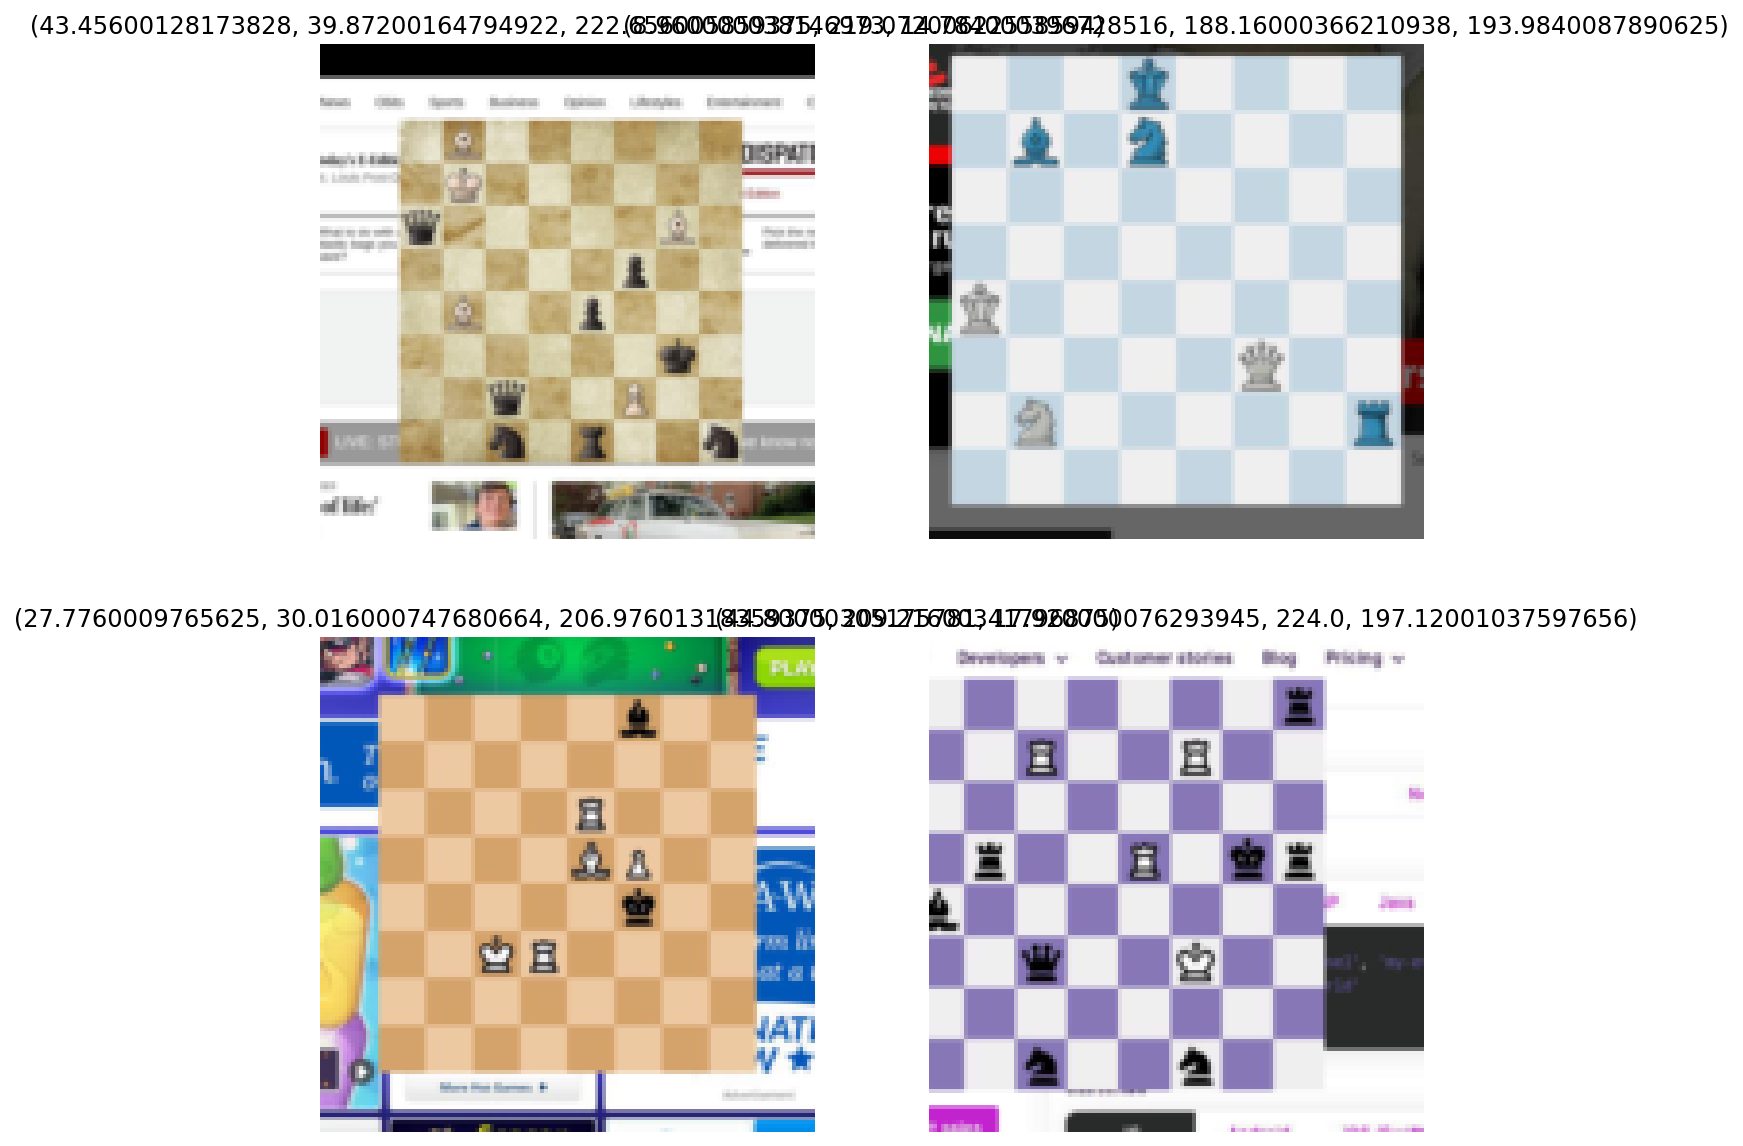

In [ ]:
dls.show_batch(nrows=2, ncols=2, figsize=(10, 10))

In [ ]:
model=resnet18

In [ ]:
learn = cnn_learner(dls, model, metrics=[MSELossFlat()], loss_func=L1LossFlat())

In [ ]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,None,time
